# Tryptophan mQTL

Candidate list for tryptophan mQTL

I chose two candidates from TRP mQTL. 

**UBP15** was selected from its connection to ubiquitin-related processes, like BUL2. It has 4 coding SNPs with moderate consequences (missense). It also has a cis- and trans-eQTLs.

**ADH2** was selected. It has 2 coding mutations with moderate consequences (i.e. missense). There is no evidence for eQTL

The two genes are adjacent (w/ open reading frames in opposite directions). 

This QTL is hard to disentangle b/c it is at the end of the chromosome. The lack of recombination there results in high degree of linkage disequilibrium. 

<img src="src/trp_mqtl.png" width="1000px"></img>

In [2]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);
library(jpeg);
library(pheatmap);
library(GenomicRanges);
library(zoo);

In [3]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

# use only relative data
endometabolite = filter(endometabolite, time_format == "relative")

#head(endometabolite)

# load expression data
load("/g/steinmetz/brooks/genphen/transcriptome/data/trx_df.rda")

# load normalized QTLs
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTLs_comball_funqtl_2014.rda")
mQTLs_funqtl_2014_class = sapply(mQTLs_funqtl_2014,class)
mQTLs_funqtl_2014 = mQTLs_funqtl_2014[mQTLs_funqtl_2014_class!="try-error"]

# load eQTLs
load("/g/steinmetz/brooks/genphen/transcriptome/qtl/eQTL_08032016.rda")

# load genotype and markers files
genotype_f = "/g/steinmetz/brooks/yeast/genomes/S288CxYJM789/genotypes_S288c_R64.rda"
load(genotype_f)

# load mQTL-eQTL correlations
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTL_eQTL_cor.RData")

# UBP15

From SGD:

Ubiquitin-specific protease involved in protein deubiquitination; forms a complex with AAA peroxins Pex1p and Pex6p; deubiquitinates mono- and polyubiquitinated forms of Pex5p; deubiquitinates Clb5p, counteracting APC activity, and facilitating both Clb5p accumulation and S phase entry; physically interacts with anaphase-promoting complex/cyclosome (APC/C) activator, Cdh1p; catalytic activity regulated by an N-terminal TRAF-like domain and and C-terminal sequences

I cannot find any direct evidence linking UBP15 to TRP metabolism

## Metabolite levels conditioning on UBP15 SNP @ chrXIII:876530..876530

UBP15 SNP @ chrXIII:876530..876530 causes missense mutation in UBP15 (YMR304W): G515D

Mutation is in the Ubiquitin carboxyl-terminal hydrolase domain

SGD variant viewer: http://www.yeastgenome.org/variant-viewer#/S000004920?_k=svglce

**NOTE** I have very little confidence in the precise SNP prediction. There are 4 missense SNPs in UBP15

In [5]:
# find marker
gr <- GRanges(seqnames = Rle(c("chr13")), ranges = IRanges(876530,876530))
thismrk = names(mrk[which(mrk == gr),])

# add geno column to endometabolite data
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

endometabolite2plot = merge(endometabolite,genotype,by = "strain")

# remove strains w/o genotype at this marker
if (length(which(is.na(endometabolite2plot$geno)))>0) {
    data2plot = endometabolite2plot[-which(is.na(endometabolite2plot$geno)),]
} else {
    data2plot = endometabolite2plot
}
# remove NA values
if (length(which(is.na(data2plot$value.log2)))>0) {
    data2plot = data2plot[-which(is.na(data2plot$value.log2)),]
}
data2plot$geno = as.factor(data2plot$geno)

# calculate mean levels per metabolite
mo = data2plot %>% group_by(metabolite) %>% summarise(m_mean = mean(value.log2, na.rm = T))
mo = mo[order(mo$m_mean, decreasing = F),]

data2plot$metabolite = factor(data2plot$metabolite, levels = mo$metabolite)

# average replicates
data2plot = data2plot %>% group_by(metabolite, time, strain) %>% do({
        data.frame(value = mean(.$value.log2, na.rm =T), geno = .$geno[1])
 })

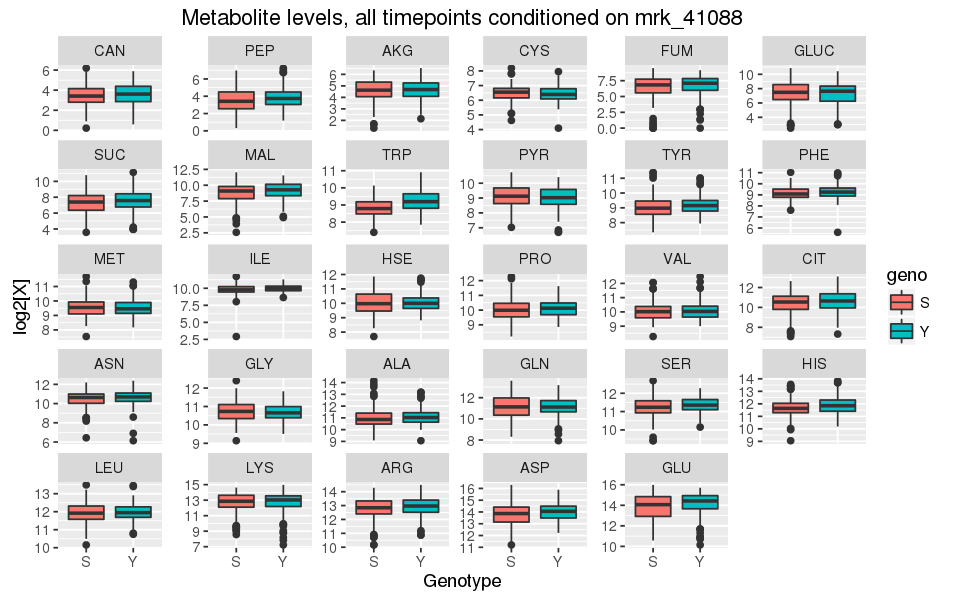

In [6]:
# plot
options(repr.plot.height = 5)
options(repr.plot.width = 8)
p <- ggplot(data2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, scales = "free_y") + 
    labs(title = paste("Metabolite levels, all timepoints conditioned on", thismrk), 
         y = "log2[X]", x = "Genotype") 
p

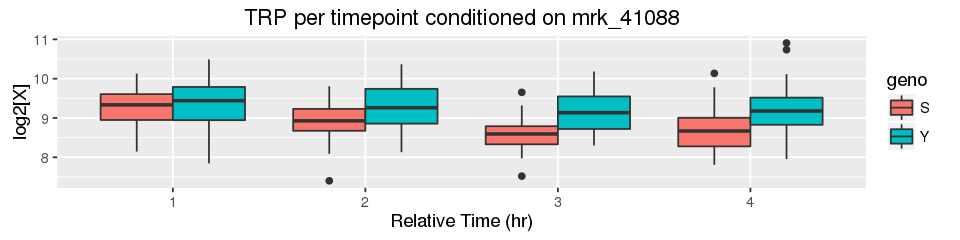

In [7]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p <- ggplot(data2plot %>% filter(metabolite %in% "TRP"), aes(factor(time), value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    labs(title = paste("TRP per timepoint conditioned on", thismrk), 
         y = "log2[X]", x = "Relative Time (hr)") 
p

In [8]:
Mmrk_dif_sig = data2plot %>% filter(metabolite %in% "TRP") %>% group_by(metabolite, time) %>% do({
    data = .
    sparent = data[data$geno=="S","value"]
    yparent = data[data$geno=="Y","value"]
    test = t.test(sparent$value, yparent$value)
    pval = test$p.value
    return(data.frame(pval))
})
Mmrk_dif_sig$pval = p.adjust(Mmrk_dif_sig$pval,method="BH")
Mmrk_dif_sig$mlog10.pval = -log10(Mmrk_dif_sig$pval)
#Mmrk_dif_sig = acast(Mmrk_dif_sig, metabolite ~ time, value.var = "pval")

Mmrk_dif_sig

,metabolite,time,pval,mlog10.pval
1,TRP,1,0.5373322,0.2697571
2,TRP,2,0.0003491814,3.456949
3,TRP,3,7.149682e-08,7.145713
4,TRP,4,0.0002026414,3.693272


## Expression levels conditioning on UBP15 SNP @ chrXIII:876530..876530

In [9]:
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

trx2plot = merge(trx_df,genotype,by = "strain")
trx2plot = trx2plot[!is.na(trx2plot$geno),]

### UBP15 itself

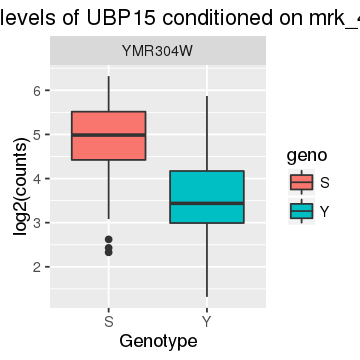

In [12]:
options(repr.plot.width = 3)
options(repr.plot.height = 3)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% "YMR304W") %>% group_by(name, strain) %>% 
    do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Transcript levels of UBP15 conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

## **NOTE**

The strong UBP15 eQTL suggests to me that the important SNP may be non-coding...

Candidate at chrXIII:874942..874942 that may interfere with TATA-box sequence?

# ADH2

From SGD:

Glucose-repressible alcohol dehydrogenase II; catalyzes the conversion of ethanol to acetaldehyde; involved in the production of certain carboxylate esters; regulated by ADR1

I cannot find any direct evidence linking ADH2 to TRP metabolism

## Metabolite levels conditioning on ADH2 SNP @ chrXIII:873817..873817

ADH2 SNP @ chrXIII:873817..873817 causes missense mutation in ADH2 (YMR303C): A174V

Mutation is not in one of the functional domains

SGD variant viewer: http://www.yeastgenome.org/variant-viewer#/S000004918?_k=ly9zq9

**NOTE** I have very little confidence in the precise SNP prediction. There are 2 missense SNPs in ADH2

In [13]:
# find marker
gr <- GRanges(seqnames = Rle(c("chr13")), ranges = IRanges(873817,873817))
thismrk = names(mrk[which(mrk == gr),])

# add geno column to endometabolite data
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

endometabolite2plot = merge(endometabolite,genotype,by = "strain")

# remove strains w/o genotype at this marker
if (length(which(is.na(endometabolite2plot$geno)))>0) {
    data2plot = endometabolite2plot[-which(is.na(endometabolite2plot$geno)),]
} else {
    data2plot = endometabolite2plot
}
# remove NA values
if (length(which(is.na(data2plot$value.log2)))>0) {
    data2plot = data2plot[-which(is.na(data2plot$value.log2)),]
}
data2plot$geno = as.factor(data2plot$geno)

# calculate mean levels per metabolite
mo = data2plot %>% group_by(metabolite) %>% summarise(m_mean = mean(value.log2, na.rm = T))
mo = mo[order(mo$m_mean, decreasing = F),]

data2plot$metabolite = factor(data2plot$metabolite, levels = mo$metabolite)

# average replicates
data2plot = data2plot %>% group_by(metabolite, time, strain) %>% do({
        data.frame(value = mean(.$value.log2, na.rm =T), geno = .$geno[1])
 })

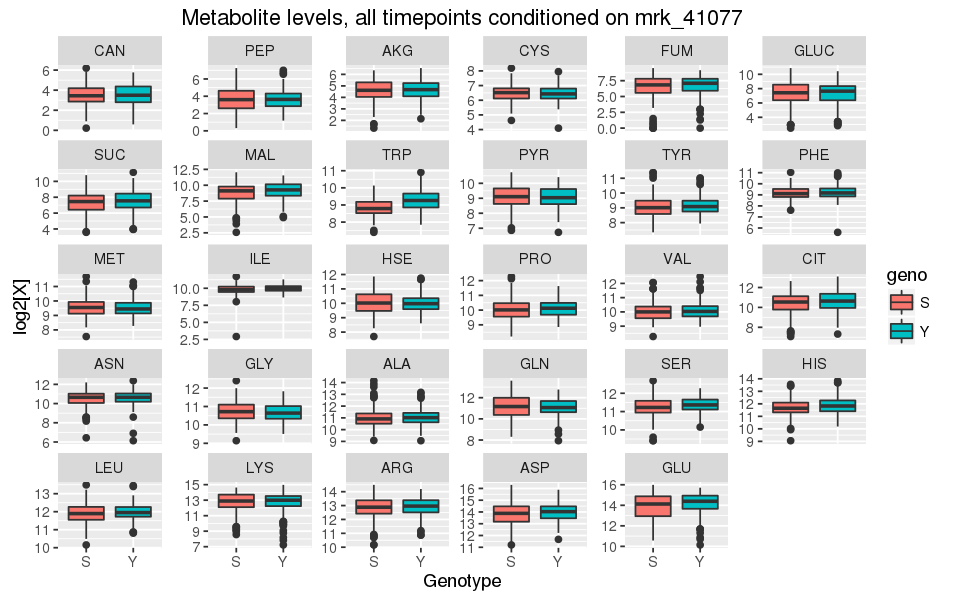

In [14]:
# plot
options(repr.plot.height = 5)
options(repr.plot.width = 8)
p <- ggplot(data2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, scales = "free_y") + 
    labs(title = paste("Metabolite levels, all timepoints conditioned on", thismrk), 
         y = "log2[X]", x = "Genotype") 
p

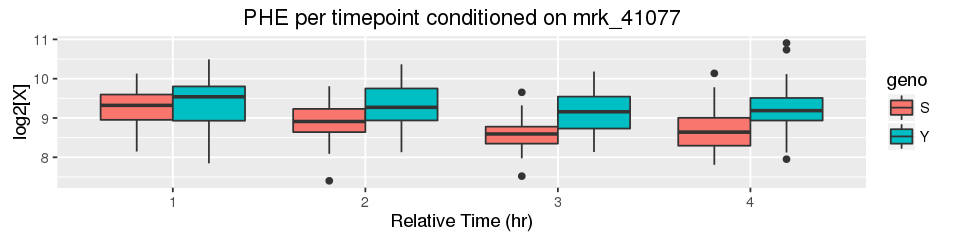

In [16]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p <- ggplot(data2plot %>% filter(metabolite %in% "TRP"), aes(factor(time), value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    labs(title = paste("PHE per timepoint conditioned on", thismrk), 
         y = "log2[X]", x = "Relative Time (hr)") 
p

In [17]:
Mmrk_dif_sig = data2plot %>% filter(metabolite %in% "TRP") %>% group_by(metabolite, time) %>% do({
    data = .
    sparent = data[data$geno=="S","value"]
    yparent = data[data$geno=="Y","value"]
    test = t.test(sparent$value, yparent$value)
    pval = test$p.value
    return(data.frame(pval))
})
Mmrk_dif_sig$pval = p.adjust(Mmrk_dif_sig$pval,method="BH")
Mmrk_dif_sig$mlog10.pval = -log10(Mmrk_dif_sig$pval)
#Mmrk_dif_sig = acast(Mmrk_dif_sig, metabolite ~ time, value.var = "pval")

Mmrk_dif_sig

,metabolite,time,pval,mlog10.pval
1,TRP,1,0.5587298,0.2527982
2,TRP,2,0.0002306883,3.636974
3,TRP,3,1.77946e-07,6.749712
4,TRP,4,0.0001103936,3.957056


## Expression levels conditioning on ADH2 SNP @ chrXIII:873817..873817

In [18]:
genotype = geno[thismrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

trx2plot = merge(trx_df,genotype,by = "strain")
trx2plot = trx2plot[!is.na(trx2plot$geno),]

### ADH2 itself

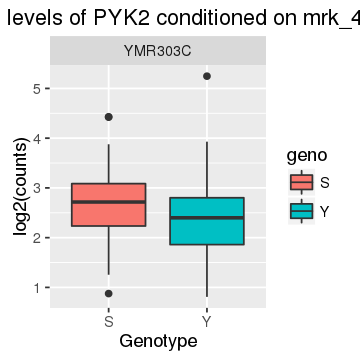

In [19]:
options(repr.plot.width = 3)
options(repr.plot.height = 3)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% "YMR303C") %>% group_by(name, strain) %>% 
    do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Transcript levels of PYK2 conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p

## Both UBP15 & ADH2

### Highly correlated mQTL-eQTL profiles, cor > 0.5

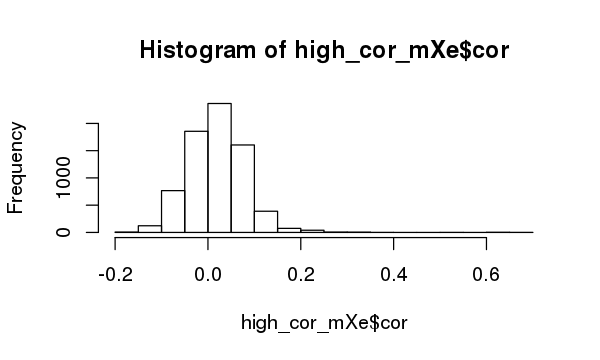

In [21]:
high_cor_mXe = mQTL_eQTL_cor %>% filter(metabolite == "TRP")
options(repr.plot.width = 5)
options(repr.plot.height = 3)
hist(high_cor_mXe$cor)
gnames = high_cor_mXe[order(high_cor_mXe$cor, decreasing = T),]
gnames = gnames %>% filter(cor >= quantile(high_cor_mXe$cor,probs=.995,na.rm=T))
gnames = gnames$gene

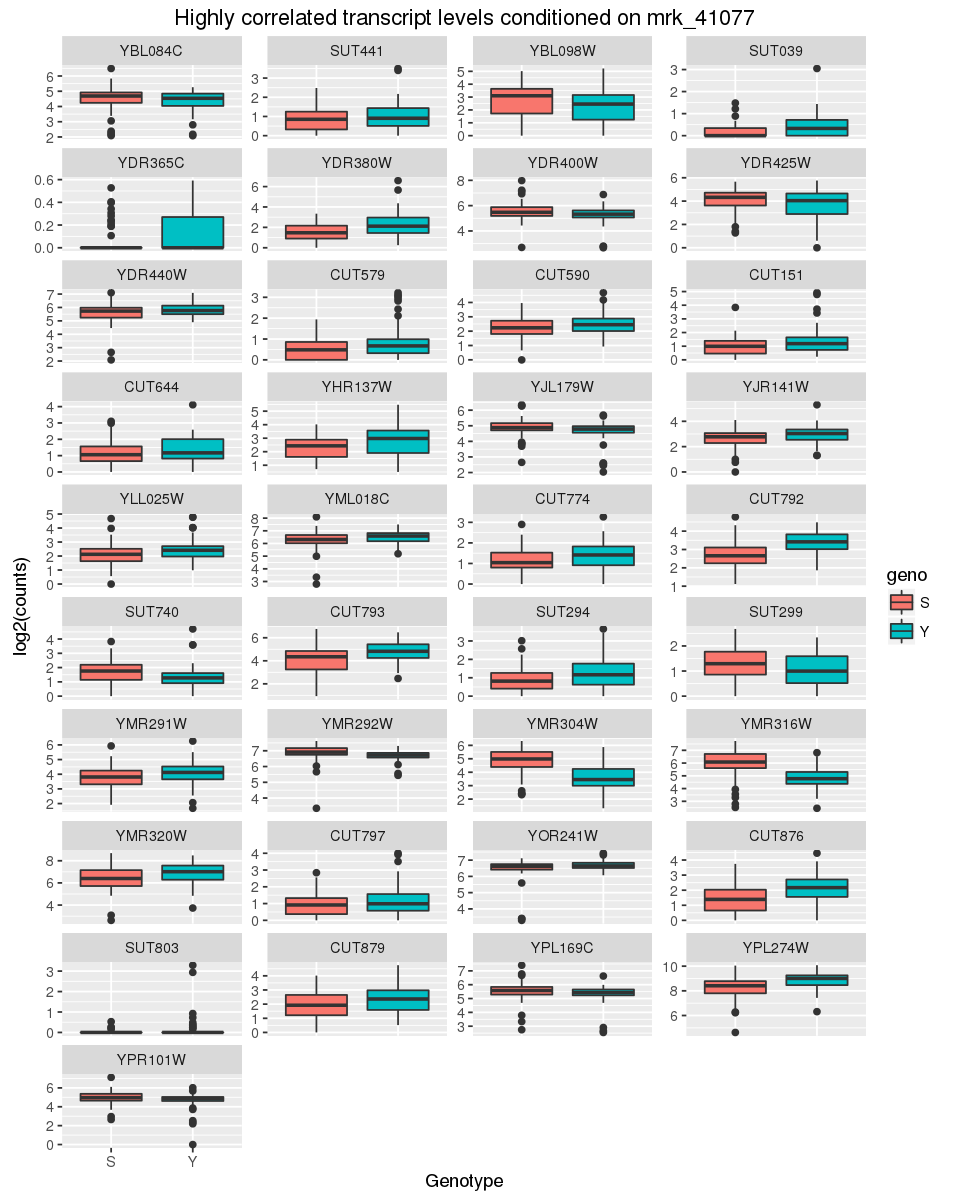

In [22]:
options(repr.plot.width = 8)
options(repr.plot.height = 10)
# average replicates
thistrx2plot = trx2plot  %>% filter(name %in% gnames) %>% group_by(name, strain) %>% do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(thistrx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Highly correlated transcript levels conditioned on", thismrk), 
         y = "log2(counts)", x = "Genotype")
p